# 오늘 할 것: 전처리 --> 외형 파악

1. 바이너리 영상 만들기
2. 도형 인식하기


- cv2.threshold()
    - cv2.THRESH_BINARY
    - cv2.THRESH_BINARY + cv2.THRESH_OTSU
- cv2.adaptiveThreshold()
    - cv2.ADAPTIVE_THRESH_GAUSSIAN_C | cv2.ADAPTIVE_THRESH_MEAN_C
    - cv2.THRESH_BINARY
- cv2.GaussianBlur()
- cv2.medianBlur()
- cv2.findContours()
- cv2.drawContours()
- cv2.arcLength()
- cv2.approxPolyDP()

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import scipy.stats as sp
from PIL import ImageFont, ImageDraw, Image

In [2]:
#함수를 그냥 만들어버린다 --> 좋은 코드는 별개 아니라 이런 거!
def imshow(tit, image):     #ndarray 타입
    plt.title(tit)
    if len(image.shape) == 3:     #채널이 3개라면(컬러) RGB로 뽑자
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:                         #채널이 3개가 아니라면(흑백) 그레이스케일로 뽑자
        plt.imshow(image, cmap = 'gray')
    plt.show()

# 1. 바이너리 영상 만들기

`threshold()`메소드를 통해서 간단하게 변환할 수 있다.
- cv2.threshold(이미지, 역치, 최댓값, cv2.THRESH_BINARY)
    - 역치 미만은 0, 이상은 최댓값으로 만든다
- 두 개의 리턴값을 갖는다.
    - 문턱, 마스크

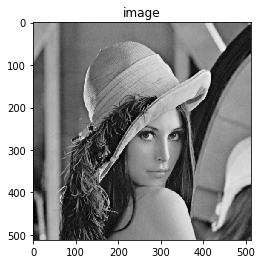

In [3]:
image = cv2.imread('lena.png', 0)    #0: 흑백으로 만들어준다 (파라미터가 없으면 컬러(BGR)로)
imshow("image", image)     #imshow("제목", 이미지)

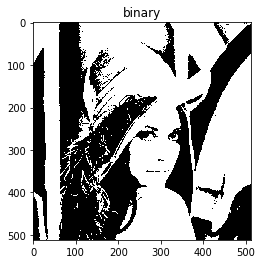

In [4]:
thr, mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
imshow('binary', mask)

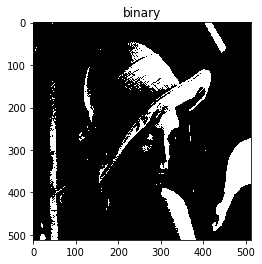

In [5]:
thr, mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
imshow('binary', mask)

역치를 어떻게 정할까?

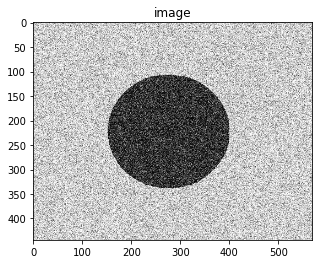

In [16]:
image = cv2.imread('circle.png', 0)
imshow("image", image)

노이즈가 너무 많다.

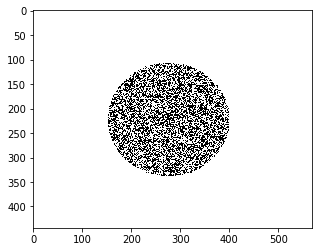

In [17]:
#일단은 그냥 해본다.
_, binary = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)     #_는 의미없는 파라미터를 받을 때 쓴다.
imshow("", binary)

역치를 낮추면 배경의 노이즈가 어느정도 걸러진다.

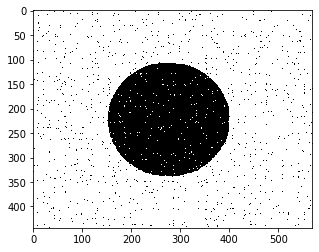

In [19]:
_, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)   #역치를 높이면 배경의 노이즈까지 나온다
imshow("", binary)

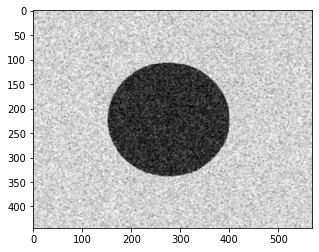

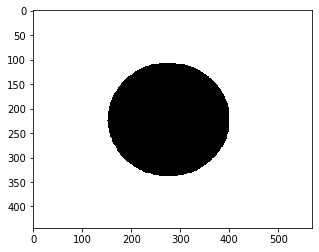

In [24]:
#블러를 해본다.
image = cv2.imread('circle.png', 0)
img_blur = cv2.GaussianBlur(image, (5, 5), 0)
_, binary = cv2.threshold(img_blur, 127, 255, cv2.THRESH_BINARY)
imshow("", img_blur)
imshow("", binary)

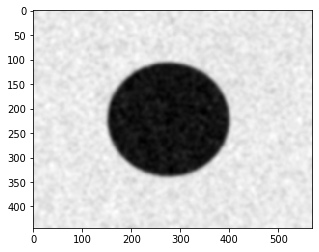

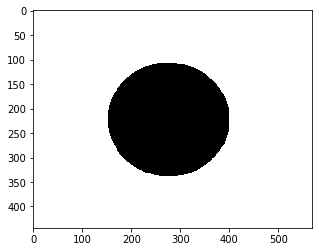

In [25]:
#블러를 더 해본다.
image = cv2.imread('circle.png', 0)
img_blur = cv2.GaussianBlur(image, (21, 21), 0)   #커널값을 높이면 된다
_, binary = cv2.threshold(img_blur, 127, 255, cv2.THRESH_BINARY)
imshow("", img_blur)
imshow("", binary)

블러 커널 크기를 높이면
- 바운더리가 좀 더 깔끔해진다.
- 대신 계산량이 많아진다.

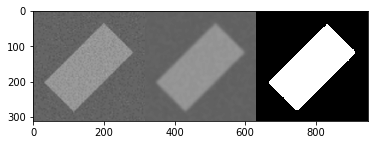

In [39]:
#다른 이미지로 해본다.
image = cv2.imread('boxnoise.png', 0)
img_blur = cv2.GaussianBlur(image, (21, 21), 0)
_, binary = cv2.threshold(img_blur, 128, 255, cv2.THRESH_BINARY)
imshow("", np.hstack([image, img_blur, binary]))

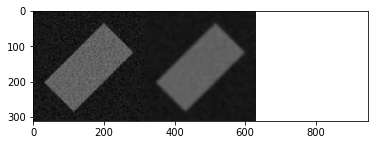

In [43]:
#다른 이미지로 해본다2
image = cv2.imread('boxnoise.png', 0)
img_blur = cv2.GaussianBlur(image, (21, 21), 0)
_, binary = cv2.threshold(img_blur, 90, 255, cv2.THRESH_BINARY)
imshow("", np.hstack([image, img_blur, binary]))

전경/배경의 밝기 차이가 크지 않기 때문에 circle.png와는 다르게 역치값을 낮게 주면 원하는 결과를 얻을 수 없다.

--> 전/배경의 밝기 차이가 크지 않으면 **"알맞은" 역치값**이 더더욱 중요해진다.

image, img_blur는 동일한 이미지이지만 다르게 보이는 이유는 plt.imshow()가 내부적으로 스케일링을 하기 때문이다.

마찬가지의 이유로 imshow("", np.hstack([image, img_blur, binary]))와 imshow("", binary)에서 binary가 다르게 출력된다.

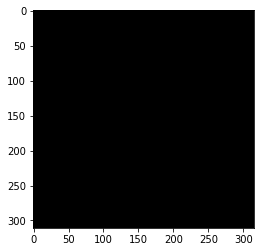

In [35]:
imshow("", binary)

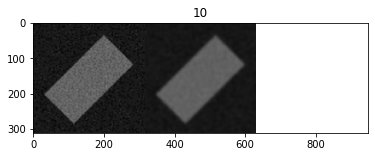

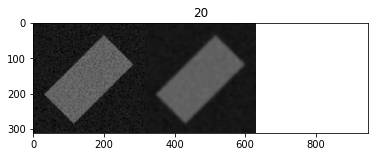

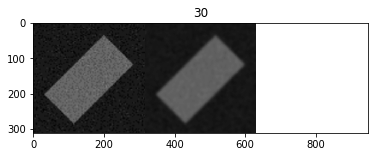

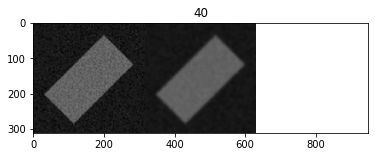

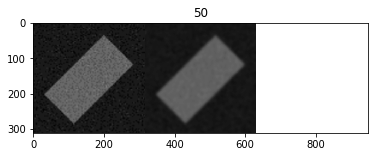

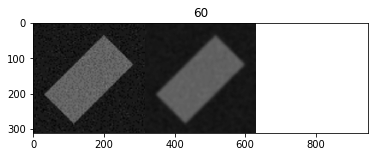

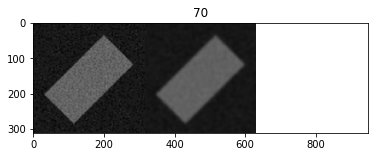

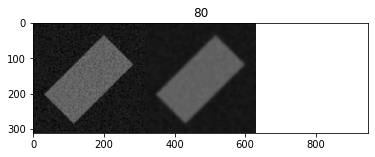

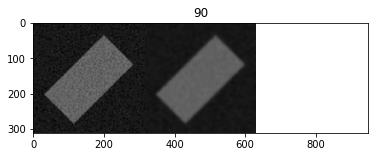

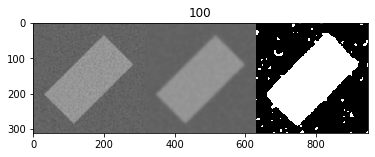

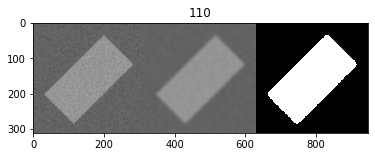

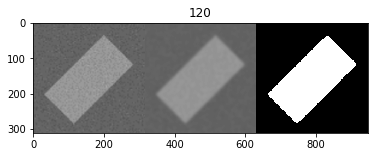

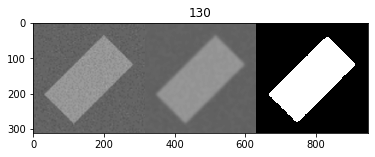

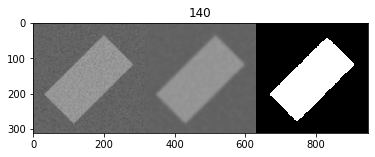

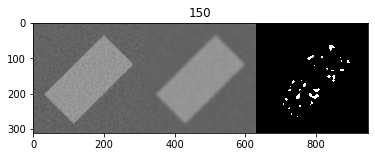

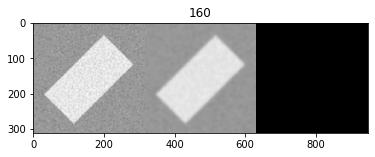

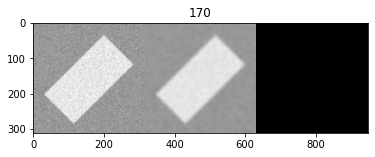

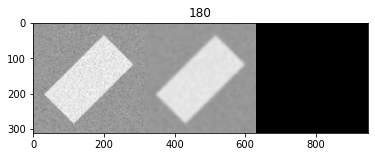

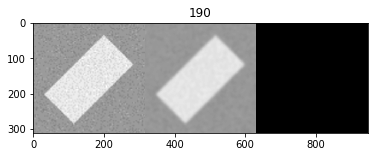

In [46]:
#for문으로 알맞은 threshold값을 찾아보자
image = cv2.imread('boxnoise.png', 0)
img_blur = cv2.GaussianBlur(image, (21, 21), 0)
for i in range(10, 200, 10):
    _, binary = cv2.threshold(img_blur, i, 255, cv2.THRESH_BINARY)
    imshow(f"{i}", np.hstack([image, img_blur, binary]))

히스토그램을 그려서 더 직관적으로 찾을 수 있다.

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

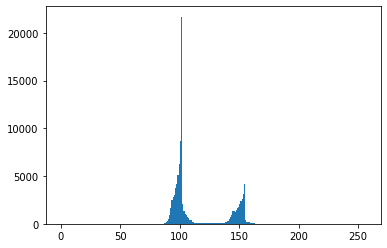

In [68]:
#히스토그램을 그려보자
plt.hist(image.ravel(), 256, [0, 256])

이미 만들어진 알고리즘을 이용하면 더더 쉽게 찾을 수 있다.

## `cv2.THRESH_OTSU`를 `threshold`메소드의 인자로 전달하는 방식으로 이용한다.
- cv2.threshold(이미지, 역치(아무거나), 최댓값, cv2.THRESH_BINARY + **cv2.THRESH_OTSU**)

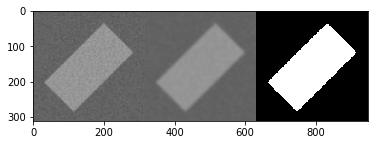

In [50]:
#THRESH_OTSU를 한번 써보자
_, binary = cv2.threshold(
    img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow("", np.hstack([image, img_blur, binary]))

"ocr image"로 검색한 이미지로 바이너리화 연습할 수 있다

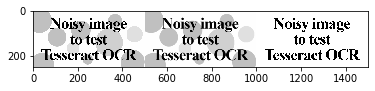

In [58]:
#읽기
img = cv2.imread("bintest.png", 0)

#블러
img_blur = cv2.GaussianBlur(img, (3, 3), 0)

#바이너리
_, binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow("", np.hstack([img, img_blur, binary]))

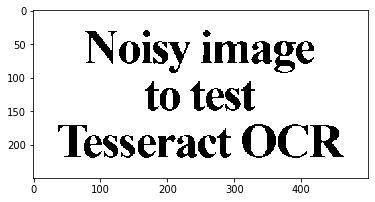

In [62]:
imshow("", binary)

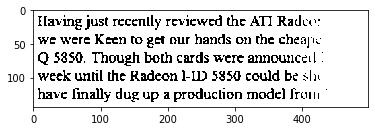

In [76]:
#읽기
img = cv2.imread("ocr-text.png", 0)

#블러
img_blur = cv2.GaussianBlur(img, (3, 3), 0)

#바이너리
_, binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow("", binary)

뒤에 글자가 잘렸다.

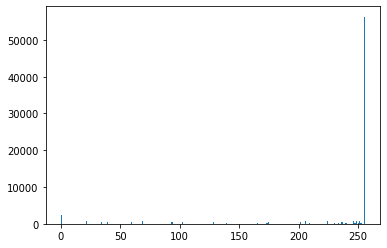

In [78]:
plt.hist(img.ravel(), 256, [0, 256])
plt.show()

### 바이너리의 한계는 "global threshold"를 쓴다는 것이다.

### --> "adaptive threshold"를 써야한다.

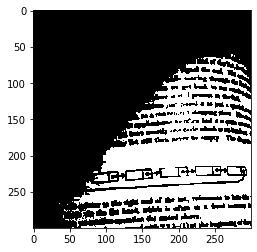

In [84]:
#읽기
img = cv2.imread("text.jpg", 0)

#블러
img_blur = cv2.GaussianBlur(img, (3, 3), 0)

#바이너리
_, binary = cv2.threshold(img_blur, 128, 255, cv2.THRESH_BINARY)   #일단 OTSU도 안 쓰고 뽑아본다
imshow("", binary)

바이너리는 망했다.

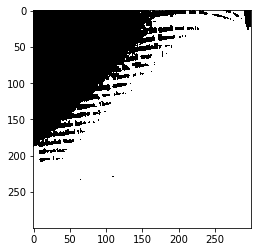

In [88]:
#바이너리
_, binary = cv2.threshold(img_blur, 60, 255, cv2.THRESH_BINARY)   #역치값을 계속 바꿔본다
imshow("", binary)

역치를 아무리 바꿔도 안된다. --> OTSU 써도 해결할 수 없다는 뜻이다.

### `adaptiveThreshold` 메소드를 활용한다.
- cv2.adaptiveThreshold(이미지, 최댓값, 평균 구할 방식, 바이너리 방식, 블럭크기, 가중치)
    - 평균 구할 방식: cv.ADAPTIVE_THRESH_GAUSSIAN_C | cv.ADAPTIVE_THRESH_MEAN_C
    - 바이너리 방식: cv2.THRESH_BINARY | cv2.THRESH_BINARY + cv.THRESH_OTSU
    - 블럭크기: 작을수록 잘게 쪼개서 계산을 수행
    - 가중치: 평균에서 얼마나 빼서 보정할지
- **'지역적으로'** 본다.
    - 구역을 나누어서 THRESH_OTSU를 수행한다고 생각하면 된다.
    - 구역별로 평균을 적용하여, 평균보다 작으면 배경, 평균보다 크면 전경으로 취급한다.
- 리턴값은 **한 개**(마스크)다.

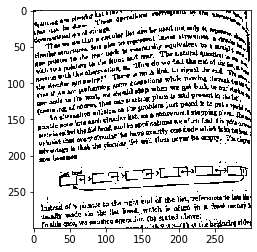

In [94]:
#adaptiveThreshold를 써보자
#읽기
img = cv2.imread("text.jpg", 0)

#바이너리 (블러도 함께 해줄거라서 미리 할 필요가 없다)
binary = cv2.adaptiveThreshold(img, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,   #평균을 구하는 방식
                                 cv2.THRESH_BINARY, 21, 5)    #21: 블럭크기, 5: 가중치; 평균에서 얼마나 뺄지
imshow("", binary)

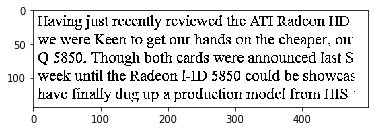

In [95]:
img = cv2.imread("ocr-text.png", 0)

#바이너리
binary = cv2.adaptiveThreshold(img, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 21, 5)
imshow("", binary)

다른 이미지로 확인해봐도 THRESH_OTSU보다는 adaptiveThreshold의 성능이 좋다는 걸 알 수 있다.

다른 이미지로 단순 binary, THRESH_OTSU, adaptiveThreshold로 바이너리화를 해본다.

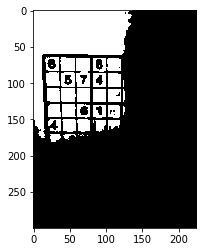

In [113]:
#단순 binary
img = cv2.imread("grid.jpg", 0)

img_blur = cv2.GaussianBlur(img, (3, 3), 0)

_, binary1 = cv2.threshold(img_blur, 128, 255, cv2.THRESH_BINARY)

imshow("", binary1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 1.900e+01, 2.200e+01, 2.200e+01, 1.700e+01,
        2.800e+01, 3.400e+01, 2.800e+01, 2.500e+01, 2.300e+01, 6.100e+01,
        5.700e+01, 7.500e+01, 5.400e+01, 8.000e+01, 7.000e+01, 9.600e+01,
        1.180e+02, 9.900e+01, 1.230e+02, 9.200e+01, 1.000e+02, 9.700e+01,
        1.500e+02, 1.080e+02, 1.340e+02, 1.810e+02, 1.340e+02, 1.570e+02,
        1.720e+02, 1.580e+02, 2.090e+02, 1.510e+02, 1.680e+02, 1.760e+02,
        1.510e+02, 1.390e+02, 1.300e+02, 1.100e+02, 1.150e+02, 1.240e+02,
        1.470e+02, 1.550e+02, 1.700e+02, 1.750e+02, 1.680e+02, 2.710e+02,
        2.630e+02, 2.800e+02, 2.550e+02, 2.750e+02, 3.410e+02, 2.880e+02,
        3.120e+02, 2.370e+02, 2.830e+02, 3.350e+02, 3.820e+02, 5.010e+02,
        5.320e+02, 5.060e+02, 6.070e+02, 6.760e+02, 6.460e+02, 6.130e+02,
        6.350e+02, 6.110e+02, 6.560e+02, 5.260e+02, 5.290e+02, 5.140e+02,
        5.280e+02, 5.460e+02, 4.790e+0

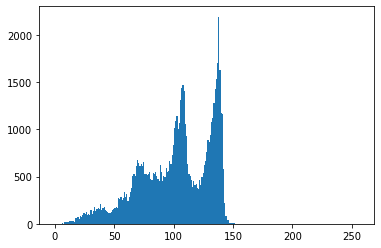

In [107]:
#히스토그램
plt.hist(img.ravel(), 255, [0, 256])

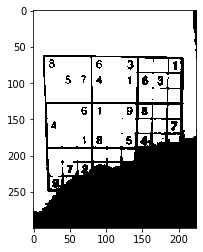

In [114]:
#THRESH_OTSU
img = cv2.imread("grid.jpg", 0)

img_blur = cv2.GaussianBlur(img, (3, 3), 0)

_, binary2 = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

imshow("", binary2)

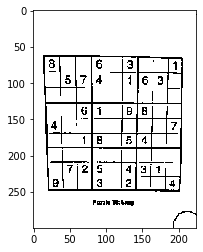

In [115]:
#adaptiveThreshold
binary3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 7)

imshow("", binary3)

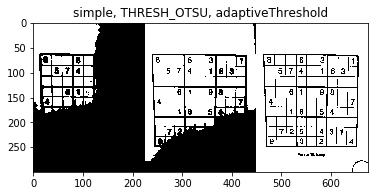

In [119]:
imshow("simple, THRESH_OTSU, adaptiveThreshold", np.hstack([binary1, binary2, binary3]))

영수증 사진으로 해보기

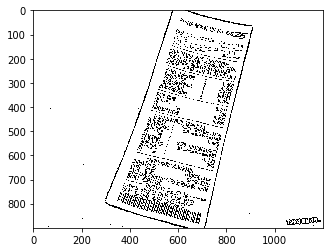

In [123]:
img = cv2.imread('receipt.png', 0)

img_blur = cv2.GaussianBlur(img, (3, 3), 0)

binary = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 7)

imshow("", binary)

In [124]:
cv2.imwrite("receipt_bin.png", binary)

True

<img src=receipt_bin.png>

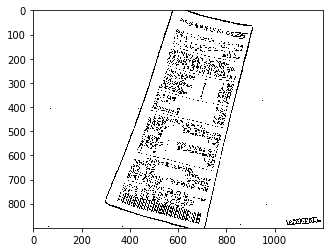

In [139]:
img = cv2.imread('receipt.png', 0)

#medianblur로도 해본다
img_blur = cv2.medianBlur(img, 3)

binary = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 7)

imshow("", binary)

In [140]:
cv2.imwrite("receipt_bin_median.png", binary)

True

<img src=receipt_bin_median.png?197541>

이 사진의 경우 미디언블러가 경계선이 조금 더 깔끔하게 따인다.

바둑돌 사진으로 해보기

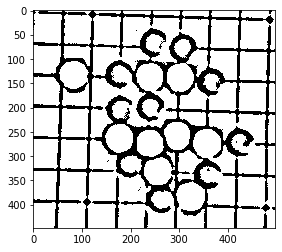

In [152]:
img = cv2.imread('stone.png', 0)

img_blur = cv2.GaussianBlur(img, (21, 21), 0)

binary = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)

imshow("", binary)

검은돌과 흰돌이 잘 구분되지 않는다.

# 2. 도형 인식하기

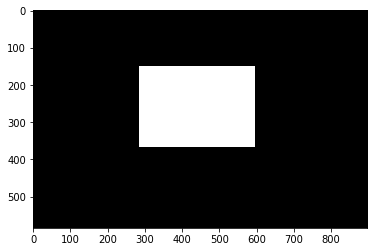

In [154]:
img = cv2.imread('shape4.png', 0)

thr, mask = cv2.threshold(img, 100, 1,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)

imshow("", mask)

**외곽선**을 찾는 방식으로 직사각형을 인식할 수 있다.

### `findContours`메소드를 활용한다.
- cv2.findContours(이미지, 외곽선 종류, cv2.CHAIN_APPROX_SIMPLE)
    - 외곽선 종류: cv2.RETR_EXTERNAL | 
    - 외곽선을 찾는 방식: cv2.CHAIN_APPROX_SIMPLE
- 리턴 값은 **두 개**다.
    - 컨투어(contours)
    - 

In [160]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #cv2.RETR_EXTERNAL: 최외곽선분

In [161]:
contours

[array([[[  0,   0]],
 
        [[  0, 583]],
 
        [[897, 583]],
 
        [[897,   0]]], dtype=int32)]

**`drawContours`** 메소드로 찾은 컨투어를 그래핑할 수 있다.
- cv2.drawContours(이미지, 컨투어, 컨투어 인덱스, 컨투어 색상, 컨투어 굵기)
    - 컨투어 인덱스: -1은 모든 컨투어
    - 컨투어 색상: (B, G, R)

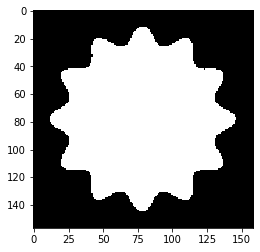

[array([[[ 76,  12]],

       [[ 72,  16]],

       [[ 72,  17]],

       [[ 71,  18]],

       [[ 71,  19]],

       [[ 70,  20]],

       [[ 70,  21]],

       [[ 68,  23]],

       [[ 68,  24]],

       [[ 67,  25]],

       [[ 66,  25]],

       [[ 65,  26]],

       [[ 60,  26]],

       [[ 59,  25]],

       [[ 58,  25]],

       [[ 57,  24]],

       [[ 56,  24]],

       [[ 55,  23]],

       [[ 54,  23]],

       [[ 52,  21]],

       [[ 50,  21]],

       [[ 49,  20]],

       [[ 45,  20]],

       [[ 43,  22]],

       [[ 43,  24]],

       [[ 42,  25]],

       [[ 42,  31]],

       [[ 43,  32]],

       [[ 43,  33]],

       [[ 42,  34]],

       [[ 42,  37]],

       [[ 41,  38]],

       [[ 41,  39]],

       [[ 39,  41]],

       [[ 38,  41]],

       [[ 37,  42]],

       [[ 25,  42]],

       [[ 24,  43]],

       [[ 22,  43]],

       [[ 20,  45]],

       [[ 20,  49]],

       [[ 21,  50]],

       [[ 21,  51]],

       [[ 22,  52]],

       [[ 22,  53]],

       [[

TypeError: 'int' object is not callable

In [192]:
img = cv2.imread('shape5.png', 0)

thr, mask = cv2.threshold(img, 0, 255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)

mask = 255 - mask

imshow("", mask)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours)

image = cv2.imread('shape5.png')
cv2.drawContours(image, contours, -1 (255, 0, 0), 10)    #-1:여러 컨투어가 있을 때 찾아진 컨투어를 모두 그린다.

imshow("", image)                                        #10:외곽선 굵기

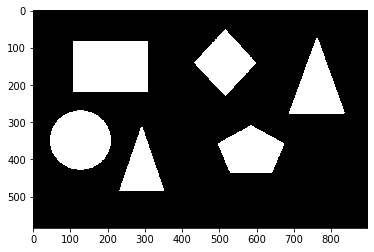

shape = 6
shape = 240    length = 513.7056245803833    approx = 3
shape = 300    length = 515.9310202598572    approx = 5
shape = 226    length = 531.8721435070038    approx = 8
shape = 4    length = 672.0    approx = 4
shape = 298    length = 616.7178171873093    approx = 3
shape = 56    length = 493.0336227416992    approx = 4


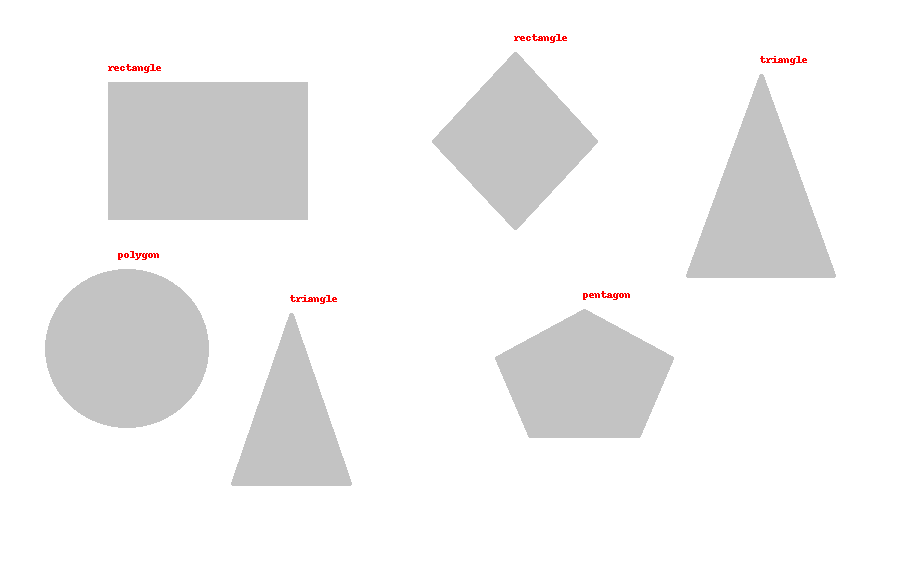

In [231]:
img = cv2.imread('shape3.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thr, mask = cv2.threshold(gray, 0, 255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = 255 - mask
imshow("", mask)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"shape = {len(contours)}")

imgPIL = Image.fromarray(img)
draw = ImageDraw.Draw(imgPIL)

for con in contours:
    
    peri = cv2.arcLength(con, True)   #컨투어 길이 구하기: cv2.arcLength(컨투어, 폐곡선 여부)
    approx = cv2.approxPolyDP(con, 0.02 * peri, True) #approximate한 좌표 구하기: cv2.approxPolyDP(컨투어, 얼만큼의 변화가 생기면 approximate할지, 폐곡선 여부)
    
    print(f"shape = {len(con)}    length = {peri}    approx = {len(approx)}")
    #컨투어 시작점 좌표
    x = con[0][0][0]
    y = con[0][0][1]
    #cv2.circle(img, (i[0], i[1]), int(i[2]*7), (0, 0, 0), -1)
    #cv2.circle(이미지, 중심좌표, 반지름, 색, 채울지말지)
    cv2.circle(img, (x, y), 5, (255, 0, 0), -1)
    cv2.drawContours(img, [approx], -1, (0, 0, 255), 2)
    
    #글씨 쓰기
    if len(approx) == 3: text = "triangle"
    elif len(approx) == 4: text = "rectangle"
    elif len(approx) == 5: text = "pentagon"
    elif len(approx) >= 6: text = "polygon"
    draw.text((x, y - 20), text, fill = (255, 0, 0))

imgPIL

# 예제) 트럼프카드 도형 인식

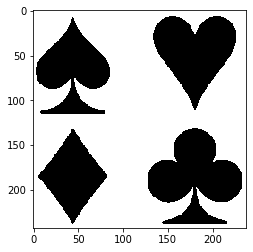

shape = 4
shape = 112    length = 272.13202953338623     approx = 4
shape = 216    length = 554.4163017272949     approx = 12
shape = 161    length = 465.24472987651825     approx = 11
shape = 176    length = 347.06096172332764     approx = 8


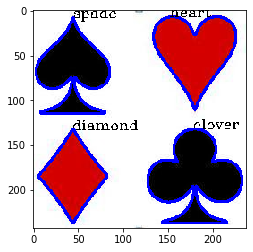

In [296]:
img = cv2.imread('trump.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_blur = cv2.GaussianBlur(gray, (3, 3), 0)

_, binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

imshow("", binary)

mask = 255 - binary

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"shape = {len(contours)}")

for con in contours:
    peri = cv2.arcLength(con, True)
    approx = cv2.approxPolyDP(con, 0.02 * peri, True)
    
    print(f"shape = {len(con)}    length = {peri}     approx = {len(approx)}")

    cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
    
    if len(approx) == 4: text = "diamond"
    elif len(approx) == 12: text = "clover"
    elif len(approx) == 11: text = "spade"
    elif len(approx) == 8: text = "heart"
        
    p = tuple(con[0][0])
    
    cv2.putText(img, text, p, 3, 0.5, (0))
    
imshow("", img)

In [298]:
cv2.imwrite("trump_labeled.png", img)

True

shape = 4
shape = 213    length = 492.1980459690094     approx = 10
shape = 264    length = 617.3279899358749     approx = 11
shape = 229    length = 568.6833263635635     approx = 10
shape = 215    length = 413.47012400627136     approx = 4


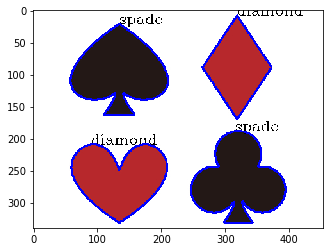

In [295]:
#다른 트럼프 이미지로도 해보자

img = cv2.imread('trump2.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

mask = 255 - mask

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"shape = {len(contours)}")

for con in contours:
    peri = cv2.arcLength(con, True)
    approx = cv2.approxPolyDP(con, 0.02 * peri, True)
    
    print(f"shape = {len(con)}    length = {peri}     approx = {len(approx)}")

    cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
    
    if len(approx) == 4: text = "diamond"
    elif len(approx) == 12: text = "clover"
    elif len(approx) == 11: text = "spade"
    elif len(approx) == 8: text = "heart"
        
    p = tuple(con[0][0])
    
    cv2.putText(img, text, p, 3, 0.7, (0))
    
imshow("", img)

제대로 라벨링이 되지 않았다.

shape = 3589


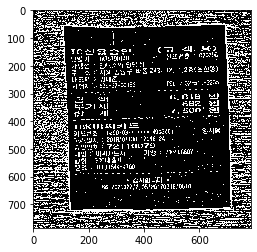

In [330]:
img = cv2.imread('rcpt2.png', 0)

img_blur = cv2.medianBlur(img, 3)

mask = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)

mask = 255 - mask

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"shape = {len(contours)}")

imshow("", mask)

사각형으로 인식되지 않고, 영수증 내부의 글씨까지 모두 컨투어로 인식된다.

# 예제2) 동전 개수 세기

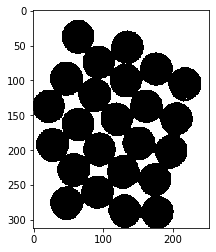

In [332]:
img = cv2.imread('water_coins.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

imshow("", binary)

이렇게 형태가 서로 붙어있을 경우 접한 면의 노이즈 때문에 컨투어 인식이 어렵다.

### `침식` 연산자를 활용해서 접한 면을 제거하는 방법을 활용할 수 있다.
cf. 반대로 경계면 내부가 비어 있는 경우에는 **`팽창`**연산자를 활용한다.
- `morphologyEX`메소드
    - 침식: `cv2.MORPH_DILATE`
        - cv2.morphologyEx(이미지, cv2.MORPH_DILATE, (3, 3), iterations = 횟수)
    - 팽창: `cv2.MORPH_ERODE`
        - cv2.morphologyEx(이미지, cv2.MORPH_ERODE, (3, 3), iterations = 횟수)
    - 침식 후 팽창: `cv2.MORPH_OPEN` ; 구멍 메꾸기
        - cv2.morphologyEx(이미지, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 횟수)
    - 팽창 후 침식: `cv2.MORPH_CLOSE`; 노이즈 없애기
        - cv2.morphologyEx(이미지, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 횟수)
        
        --> 침식 후 팽창 / 팽창 후 침식: 기본적인 이미지가 유지된다.

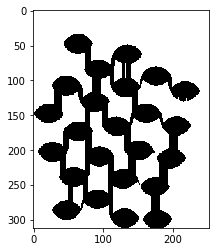

In [343]:
#침식
dilated = cv2.morphologyEx(binary, cv2.MORPH_DILATE, (3, 3), iterations = 20)
imshow("", dilated)

구분이 좀 더 명확해졌다.

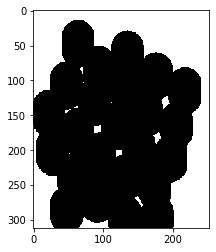

In [350]:
#팽창
eroded = cv2.morphologyEx(binary, cv2.MORPH_ERODE, (3, 3), iterations = 20)
imshow("", eroded)

빈 공간이 메꿔졌다.

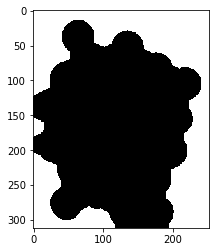

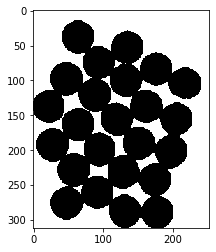

In [348]:
#침식 후 팽창: cv2.MORPH_OPEN; 구멍 메꾸기
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 5)
imshow("", opened)

#팽창 후 침식: cv2.MORPH_CLOSE; 노이즈 없애기
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 5)
imshow("", closed)